**Table of contents**<a id='toc0_'></a>    
- [AI Tools Declaration](#toc1_)    
- [Prediction Metrics](#toc2_)    
- [Question 1](#toc3_)    
  - [Dataset Overview](#toc3_1_)    
  - [Visual Data Exploration](#toc3_2_)    
  - [Choosing the Right Metric](#toc3_3_)    
  - [Benchmarking a Random Classifier](#toc3_4_)    
  - [Understanding AUC Metrics for Random Classifier](#toc3_5_)    
- [Question 2](#toc4_)    
  - [Metrics](#toc4_1_)    
  - [AUC](#toc4_2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[AI Tools Declaration](#toc0_)

In [129]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, precision_recall_fscore_support, average_precision_score

X_train = np.loadtxt("Xtrain.csv")
Y_train = np.loadtxt("Ytrain.csv")
X_test = np.loadtxt("Xtest.csv")

# <a id='toc2_'></a>[Prediction Metrics](#toc0_)

# <a id='toc3_'></a>[Question 1](#toc0_)

## <a id='toc3_1_'></a>[Dataset Overview](#toc0_)

In [37]:
np.unique_counts(Y_train)

UniqueCountsResult(values=array([-1.,  1.]), counts=array([2386,  614]))

a) Training set: There are 2386 negative examples, 614 positive examples. Test set: Unknown.

b) There is some class imbalance in the training data, with a N:P ratio of about 4:1. This causes some potential issues in designing a machine learning solution. With an overrepresented negative class, a trained model may exhibit high specificity but low precision, i.e. it focuses more on correctly predicting the negative class. There may be a high number of false negative predictions. 

## <a id='toc3_2_'></a>[Visual Data Exploration](#toc0_)

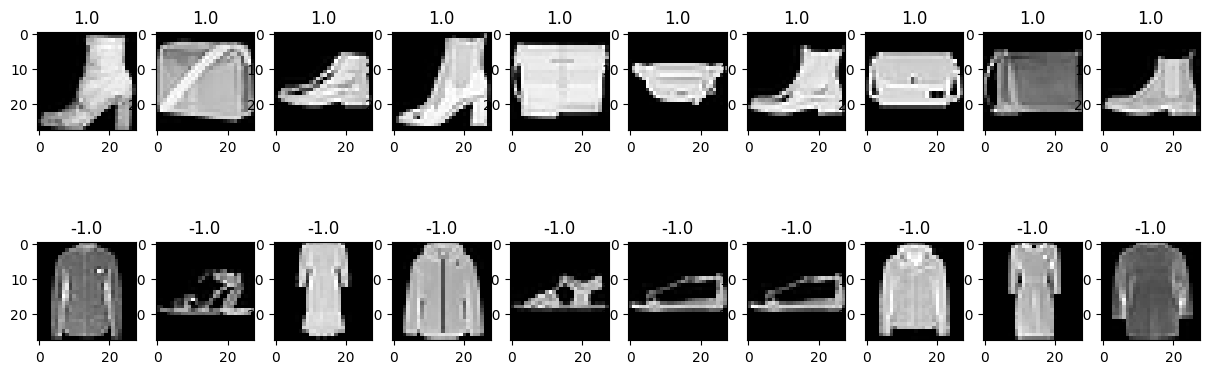

In [38]:
negative_idx = np.asarray(Y_train == -1).nonzero()
positive_idx = np.asarray(Y_train == 1).nonzero()

plt.figure(figsize=(15,5))
for i, idx in enumerate(np.random.choice(positive_idx[0], 10)):
    plt.subplot(2, 10, i+1)
    plt.imshow(X_train[idx].reshape((28,28)), cmap="gray")
    plt.title(Y_train[idx])

for i, idx in enumerate(np.random.choice(negative_idx[0], 10)):
    plt.subplot(2, 10, 10+i+1)
    plt.imshow(X_train[idx].reshape((28,28)), cmap="gray")
    plt.title(Y_train[idx])
plt.show()

a) The classes seem to be split by type of clothing. Ankle boots and bags always appear in the class with label 1. Shirts, trainers, trousers and other footwear, tops, and dresses always appear in the class with label -1. This is likely taken from the [Fashion MNIST](https://www.kaggle.com/datasets/zalando-research/fashionmnist) dataset, which originally has 10 classes. It appears that the first eight classes have been assigned the label -1, and the other two are assigned the label 1. 

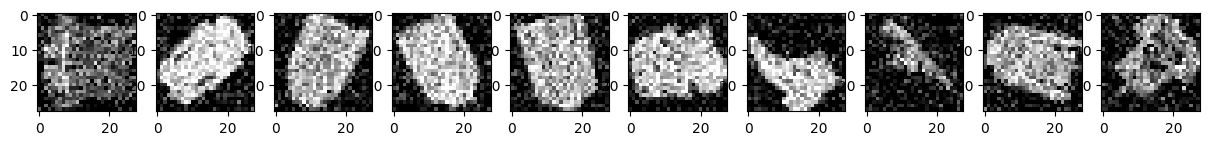

In [39]:
plt.figure(figsize=(15,5))
for i, idx in enumerate(np.random.choice(X_test.shape[0], 10)):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_test[idx].reshape((28,28)), cmap="gray")
plt.show()


b) The test examples have noise added and are also in a variety of rotations. In order for the classifier to generalise, it must be noise and rotation invariant. 

## <a id='toc3_3_'></a>[Choosing the Right Metric](#toc0_)

Accuracy alone is not a good metric for this task. This is because of the class imbalance. An accuracy of 80% could be achieved in this dataset simply by always predicting the majority class (negative). Despite the high accuracy, this classifier will have zero precision and recall. AUC-ROC suffers from a similar issue where it may not represent imbalanced classes very well. Therefore it makes sense to look at metrics that involve the precision and recall - such as AUC-PR, F1, and Matthews Correlation Coefficient.

## <a id='toc3_4_'></a>[Benchmarking a Random Classifier](#toc0_)
We would expect the accuracy on both the test and training datasets to be 50%. This is because for any given example, the classifier has a 50% chance of predicting the correct class, as there are two classes.

In [121]:
probs = np.random.uniform(-1, 1, X_train.shape[0]) # Random guess for each example 
preds[probs > 0] = 1
preds[probs < 0] = -1
print(f"Number of correct guesses: {(preds==Y_train).sum()} out of {X_train.shape[0]}"
      f" giving {round((preds==Y_train).sum() / X_train.shape[0] * 100, 2)}% accuracy") # Output is always close to 50% 

Number of correct guesses: 1520 out of 3000 giving 50.67% accuracy


The result would be the same for the test set, if we had labels for it. Class imbalance doesn't affect this result. 

## <a id='toc3_5_'></a>[Understanding AUC Metrics for Random Classifier](#toc0_)
The ROC curve for a random classifier would be a line through the diagonal, so the AUC-ROC metric would be about half of the theoretical maximum. 


0.5000320818236674

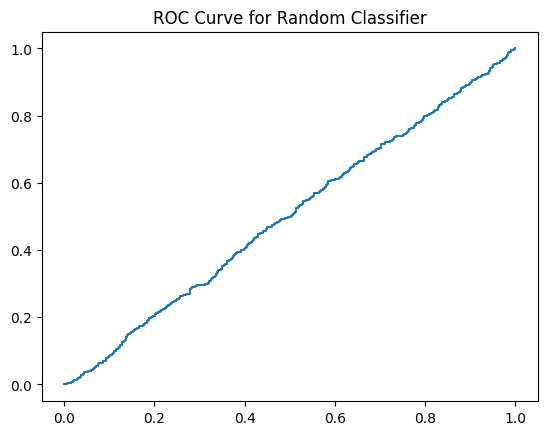

In [128]:
fpr, tpr, thresholds = roc_curve(Y_train, probs)
plt.plot(fpr, tpr)
plt.title("ROC Curve for Random Classifier")
float(roc_auc_score(Y_train, probs)) # ROC AUC score is about 50%, which is the worst possible ROC. 

For the PR curve, at a high threshold, a small number of examples are predicted positive, about a fifth of which actually are positive (as the positive class makes up a fifth of the dataset). At a threshold of -1, all the examples are predicted positive, again about a fifth of these are actually positive. So no matter the threshold, the precision should be around a fifth. To be precise, it should tend to a fifth as the threshold tends to -1. As the threshold decreases, more and more examples are predicted as positive, which means the true positive rate increases. So we expect a vertical line centered at a precision of roughly 0.2.

For PR curves, we don't usually use an AUC metric. Instead we use the average precision. Based on the expected shape of the PR curve we would expect an average precision of 0.2, compared to the theoretical maximum of 1. 

0.20138993961479054

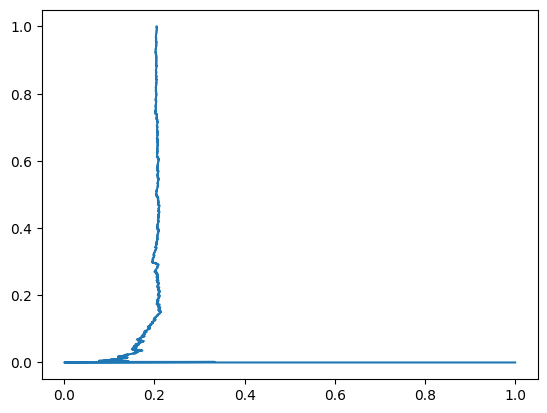

In [130]:
precision, recall, thresholds = precision_recall_curve(Y_train, probs)
plt.plot(precision, recall)
float(average_precision_score(Y_train, probs))


# <a id='toc4_'></a>[Question 2](#toc0_)

## <a id='toc4_1_'></a>[Metrics](#toc0_)

The **accuracy** is given by the number of correctly classified examples divided by the number of examples. Equivalently, 
$$ Acc = \frac{TP + TN}{TP + TN + FP + FN} $$
The **[balanced accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html)** is a metric used to deal with imbalanced datasets, defined as the average of recall obtained on each class, where recall is given by $\frac{TP}{TP+FN}$

**AUC-ROC** is the area under the ROC curve. The ROC curve is obtained by plotting the true positive rate (recall) against the false positive rate (given by $\frac{FN}{TP + FN}$) for a set of threshold values.

**AUC-PR** is the area under the PR curve. The PR curve is obtained by plotting the true positive rate (recall) against precision (given by $\frac{TP}{FP+TP}$) for a set of threshold values. 

The **[F1 score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html)** is the harmonic mean of the precision and recall, given by $\frac{2 \cdot TP}{2 \cdot TP + FP + FN}$

The **[Matthews correlation coefficient](https://en.wikipedia.org/wiki/Phi_coefficient)** or phi coefficient takes into account all four squares of the confusion matrix. It is given by
$$\frac{TP \times TN - FP \times FN}{\sqrt{(TP+FP)(TP+FN)(TN+FP)(TN+FN)}}$$

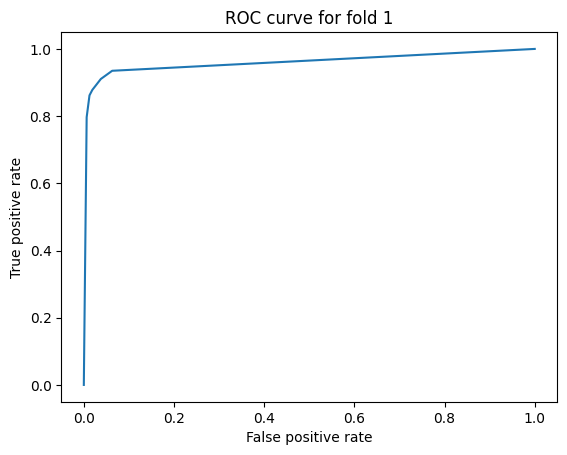

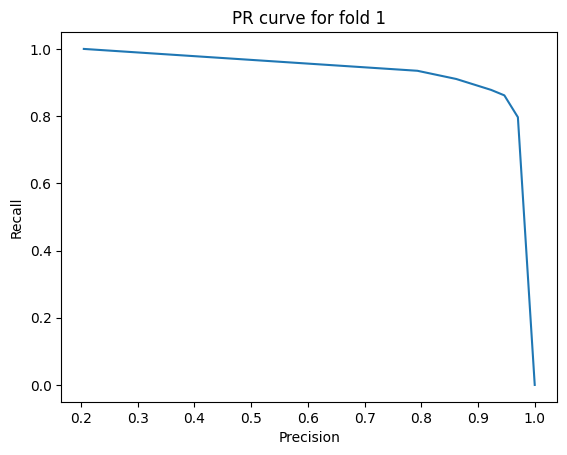

Metric			Mean	Standard Deviation
accuracy		0.965	0.0059
balanced accuracy	0.943	0.009
auc-roc			0.972	0.01
auc-pr			0.935	0.0178
f1-score		0.913	0.0141
matthews		0.891	0.0177


In [156]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import balanced_accuracy_score, f1_score, matthews_corrcoef
from sklearn.neighbors import KNeighborsClassifier

skf = StratifiedKFold(n_splits=5)
knn =  KNeighborsClassifier(5)

accuracies = []
balanced_accuracies = []
auc_rocs = []
auc_prs = []
f1s = []
mccs = []

for i, (train_idx, test_idx) in enumerate(skf.split(X_train, Y_train)):
    Xtr, Ytr = X_train[train_idx], Y_train[train_idx]
    Xval, Yval = X_train[test_idx], Y_train[test_idx]

    knn.fit(Xtr, Ytr)
    Y_pred = knn.predict(Xval)

    accuracy = (Y_pred==Yval).sum() / Yval.shape[0]
    balanced_accuracy = balanced_accuracy_score(Yval,Y_pred)

    # Need to use predict_proba for knn auc 
    y_scores = knn.predict_proba(Xval)
    fpr, tpr, thresholds = roc_curve(Yval, y_scores[:, 1])
    precision, recall, thresholds = precision_recall_curve(Yval, y_scores[:, 1])

    auc_roc = roc_auc_score(Yval, y_scores[:, 1])
    auc_pr = average_precision_score(Yval, y_scores[:, 1])

    f1 = f1_score(Yval, Y_pred)
    mcc = matthews_corrcoef(Yval, Y_pred)

    if i == 1: # plot the roc and pr curves for the first fold
        plt.plot(fpr, tpr)
        plt.title("ROC curve for fold 1")
        plt.xlabel("False positive rate")
        plt.ylabel("True positive rate")
        plt.show()
        plt.plot(precision, recall)
        plt.title("PR curve for fold 1")
        plt.xlabel("Precision")
        plt.ylabel("Recall")
        plt.show()

    accuracies.append(accuracy)
    balanced_accuracies.append(balanced_accuracy)
    auc_rocs.append(auc_roc)
    auc_prs.append(auc_pr)
    f1s.append(f1)
    mccs.append(mcc)

print("Metric\t\t\tMean\tStandard Deviation")
for mname, metric in {'accuracy\t': accuracies, 'balanced accuracy': balanced_accuracies, 
                      'auc-roc\t\t': auc_rocs, 'auc-pr\t\t': auc_prs, 'f1-score\t': f1s, 'matthews\t': mccs}.items():
    mean = np.mean(metric)
    sd = np.std(metric)
    print(f"{mname}\t{round(mean, 3)}\t{round(sd, 4)}")



## <a id='toc4_2_'></a>[AUC](#toc0_)

We notice that the ROC and PR curves both have high areas. For the ROC, we're particularly interested in the top left corner of the graph, where we have both a high true positive rate and a low false positive rate. Note that we can achieve a TPR of over 0.9 while keeping below a 0.1 FPR. This would suggest a strong classifier, but to confirm, we should check the PR curve which can better represent class imbalances. The PR curve staying close to the top-right corner indicates that the classifier has good precision for unbalanced classes. 